In [1]:
import numpy as np
import pandas as pd

from gtda.time_series import SlidingWindow
from gtda.diagrams import PersistenceLandscape
from gtda.homology import VietorisRipsPersistence

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.set_option('display.max_columns', None)
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
# !pip install spectrum 
# from spectrum.periodogram import speriodogram

import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess

from pylab import *

import matplotlib.gridspec as gridspec

from statsmodels.tsa.seasonal import seasonal_decompose

from spectrum import Periodogram

In [2]:
# Functions to compute the Lp norms

# Find the range of x values from the persistence diagram:
#### THIS FUNCTION ULTIMATELY DID NOT GET USED#####
def Ftseq(diagram):
    births =[]
    deaths =[]
    for pair in diagram:
        if pair[2] == 1:
            births.append(pair[0])
            deaths.append(pair[1])
    return np.linspace(min(births), max(deaths), 100)

# Calculate Lp norm:
##### AUCORIGINAL AND AUCUPDATED ARE METHODS BY AREA UNDER THE CURVE. THEY DID NOT GET USED. 
##### ONLY THE ELSE STATEMENT GETS USED IN THE COMPUTATION #########
def Lpnorm(tseq, landscapevalues, p = 1):
    norms = []
    if p == 'aucoriginal':
        layervalues = landscapevalues[layers]
        for point in zip(tseq,layervalues):
            norms.append(np.trapz(layervalues, tseq))
        return(sum(norms))
    elif p == 'aucUpdated':
        layervalues = landscapevalues[layers]
        return (np.trapz(layervalues))
    else:
        normvalues = []
        for layer in range(layers, 2*layers):
            layervalues = landscapevalues[layer]
            normvalue = np.linalg.norm(layervalues,p)**p
            if normvalue == 0:
                break
            else: 
                normvalues.append(normvalue)
        return (np.sum(normvalues)**(1/p))

In [3]:
# computation of L1 norms of SWE
def sweL1(ts, lag, windowsize, landscapelayers, functionname = 'f(x) = sin(π*x/4)'):
    # Make layers and i global variables so it can be referenced in the helper functions
    global layers
    layers = landscapelayers
    global i
    
    # labels for the plots
    labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5π/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
    plt.style.use('seaborn-darkgrid')
    
    # plot the sin function itself
    if i == 1:
        plt.subplot(9,1,i)
        plt.plot(y1)
        plt.subplots_adjust(hspace=.5)
        plt.title(functionname, loc='left', weight = 'bold')
        plt.xlabel('x')
        plt.xlim([-20,820])
        i +=1
        
    # delay the time series with paramater 'lag'
    simulated_data = pd.DataFrame({'Simulated Data 1' : ts})
    simulated_data['Simulated Data 2'] = simulated_data['Simulated Data 1'].shift(lag)
    simulated_data = simulated_data.dropna()

    # Create sliding windows
    window_size = windowsize
    stride = 1
    df = simulated_data
    X = df
    y = df.index
    SW = SlidingWindow(size=window_size, stride=stride)
    X_sw, yr = SW.fit_transform_resample(X, y)

    # Calculate the norms, correlations and variabilities for each of the windows in the SWE
    variabilitys = np.empty(window_size -1 + lag)
    variabilitys[:] = np.nan
    variabilitys = list(variabilitys)

    correlations = np.empty(window_size -1 + lag)
    correlations[:] = np.nan
    correlations = list(correlations)
    
    Norms = np.empty(window_size-1 + lag)
    Norms[:] = np.nan
    Norms = list(Norms)
    
    l2Norms = np.empty(window_size-1 + lag)
    l2Norms[:] = np.nan
    l2Norms = list(l2Norms)
    
    # compute rips filtration, p diagram, p landscape and norms. Append accordingly.
    vrp = VietorisRipsPersistence()
    pl = PersistenceLandscape(layers)
    for pointcloud in X_sw:
        persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
        landscapedata = pl.fit_transform(persistencediagram)
        tseq = Ftseq(persistencediagram[0])
        Norms.append(Lpnorm(tseq, landscapedata[0], p = 1))    
        l2Norms.append(Lpnorm(tseq, landscapedata[0], p = 2))
        pointcloudcovmatrix = np.array(pd.DataFrame(pointcloud).cov())
        variabilitys.append((pointcloudcovmatrix[0][0]  + pointcloudcovmatrix[1][1]) / 2)
        pointcloudcorrmatrix = np.array(pd.DataFrame(pointcloud).corr())
        correlations.append(np.round(pointcloudcorrmatrix[0][1], 5))
    
    # Normalizing
    simulateddata1normalized = simulated_data['Simulated Data 1']/simulated_data['Simulated Data 1'].max()
    simulateddata2normalized = simulated_data['Simulated Data 2']/simulated_data['Simulated Data 2'].max()
    NormsNoramlized = np.array(Norms) / pd.Series(Norms).max() if pd.Series(Norms).max() != 0 else np.array(Norms)*0
#     l2Norms = np.array(l2Norms) / pd.Series(l2Norms).max() if pd.Series(l2Norms).max() != 0 else np.array(l2Norms)*0
    variabilitys = np.array(variabilitys) / pd.Series(variabilitys).max() if pd.Series(variabilitys).max() != 0 else np.array(variabilitys)*0

    # Plotting
    if (lag != 0) & (i <= 9):
        plt.style.use('seaborn-darkgrid')
        plt.subplot(9,1,i)
        plt.subplots_adjust(hspace=.5)
        plt.plot(variabilitys, color = 'blueviolet', label = 'Variability (Normalized)')
        corrlabel = 'Correlation'
        plt.plot(correlations, color = 'orange', label = corrlabel)
        plt.plot(NormsNoramlized, color = 'black', label = 'L1 Norm (Normalized)')
        plt.title(str(labels[i-1]) + ' Embedding', fontweight = 'bold', loc='left')
        plt.xlabel('x')
        plt.xlim([-20,820])
        i +=1

    # Return average norms
    return pd.Series(Norms).mean()
    

In [4]:
# demonstrate the embeddings and scatter plots
def embeddingdemo(ts):
    labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5π/4', '3π/2', '7π/4', '2π',
                   '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']

    plt.figure(figsize = (16,18))
    i = 1
    for lag in range(10,90, 10):
        simulated_data = pd.DataFrame({'Simulated Data 1' : y1
                     })
        simulated_data['Simulated Data 2'] = simulated_data['Simulated Data 1'].shift(lag)
        simulated_data = simulated_data.dropna()

        plt.subplot(8,1,i)
        plt.subplots_adjust(hspace=.5)
        plt.plot(simulated_data['Simulated Data 1'], color = 'blue', label = 'Sine Wave')
        plt.plot(simulated_data['Simulated Data 2'], color = 'red', label = 'Embedding')
        plt.title(str(labels[i]) + ' Embedding')
        i+=1
    plt.show()



    plt.figure(figsize = (16,18))
    i = 1
    for lag in range(10,90, 10):
        simulated_data = pd.DataFrame({'Simulated Data 1' : y1
                     })
        simulated_data['Simulated Data 2'] = simulated_data['Simulated Data 1'].shift(lag)
        simulated_data = simulated_data.dropna()

        plt.subplot(4,2,i)
    #     plt.subplots_adjust(hspace=.5)
        sns.scatterplot(simulated_data['Simulated Data 1'], simulated_data['Simulated Data 2'])
        plt.title(str(labels[i]) + ' Embedding')
        plt.xlabel('')
        plt.ylabel('')
        i+=1
    plt.show()    
    

### Demonstration of Phase Delay Embeddings

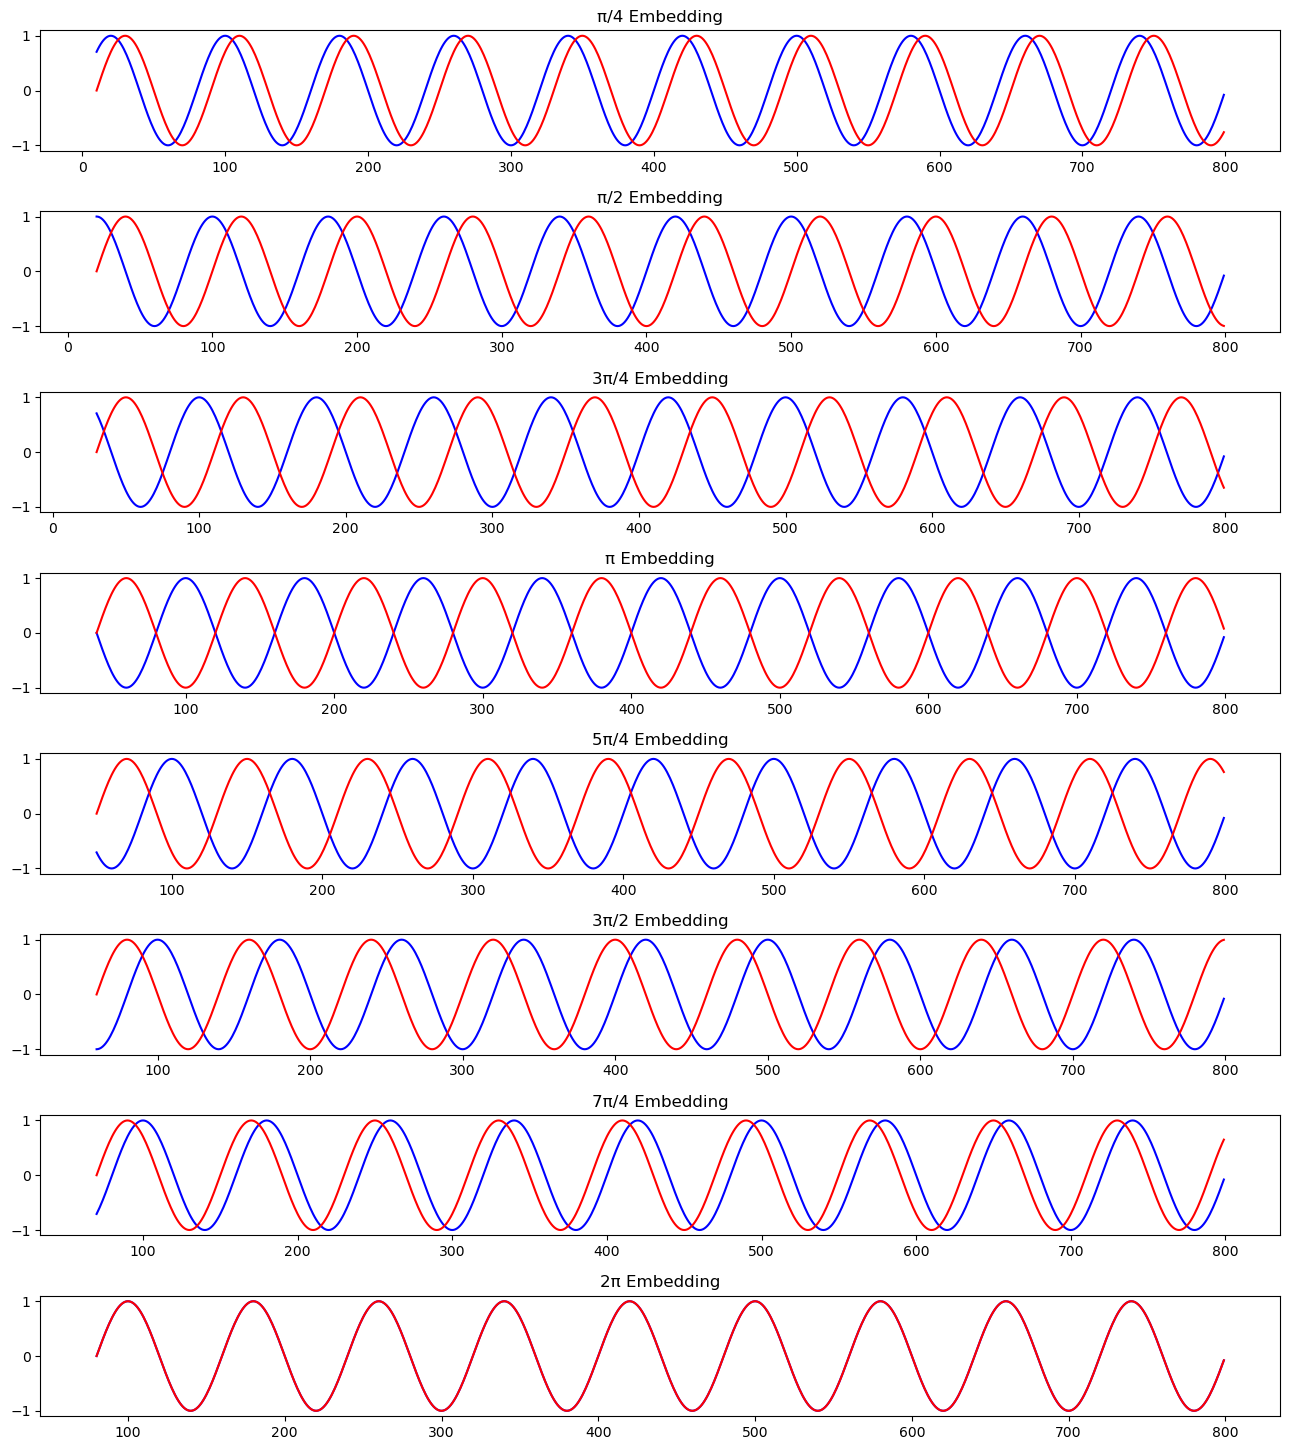

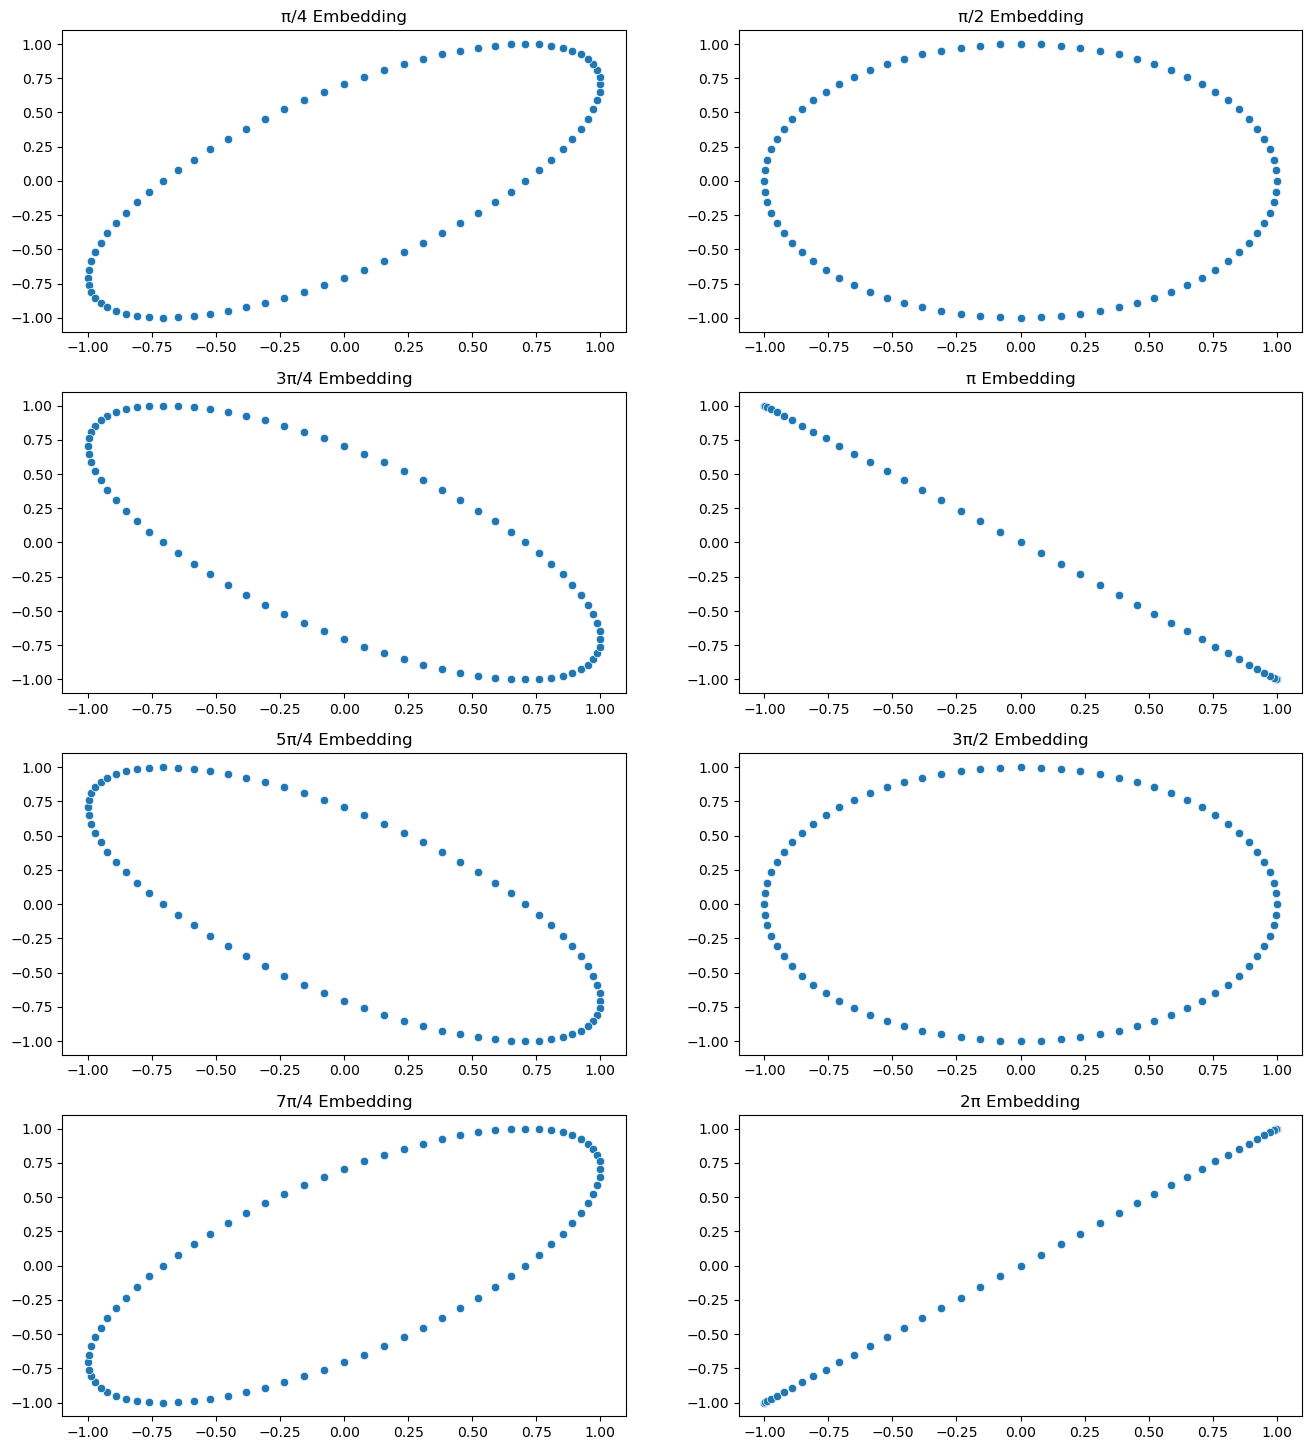

In [5]:
# Create time series
x = np.arange(0, 80, .1)
f1 =  math.pi * (1/4)
np.random.seed(0)
np.random.seed(42)
y1 = (np.sin(f1*x) 
#             + np.random.normal(scale=.1, size=len(x))
)
y1 = np.round(y1, 5)

embeddingdemo(y1)

## No Noise

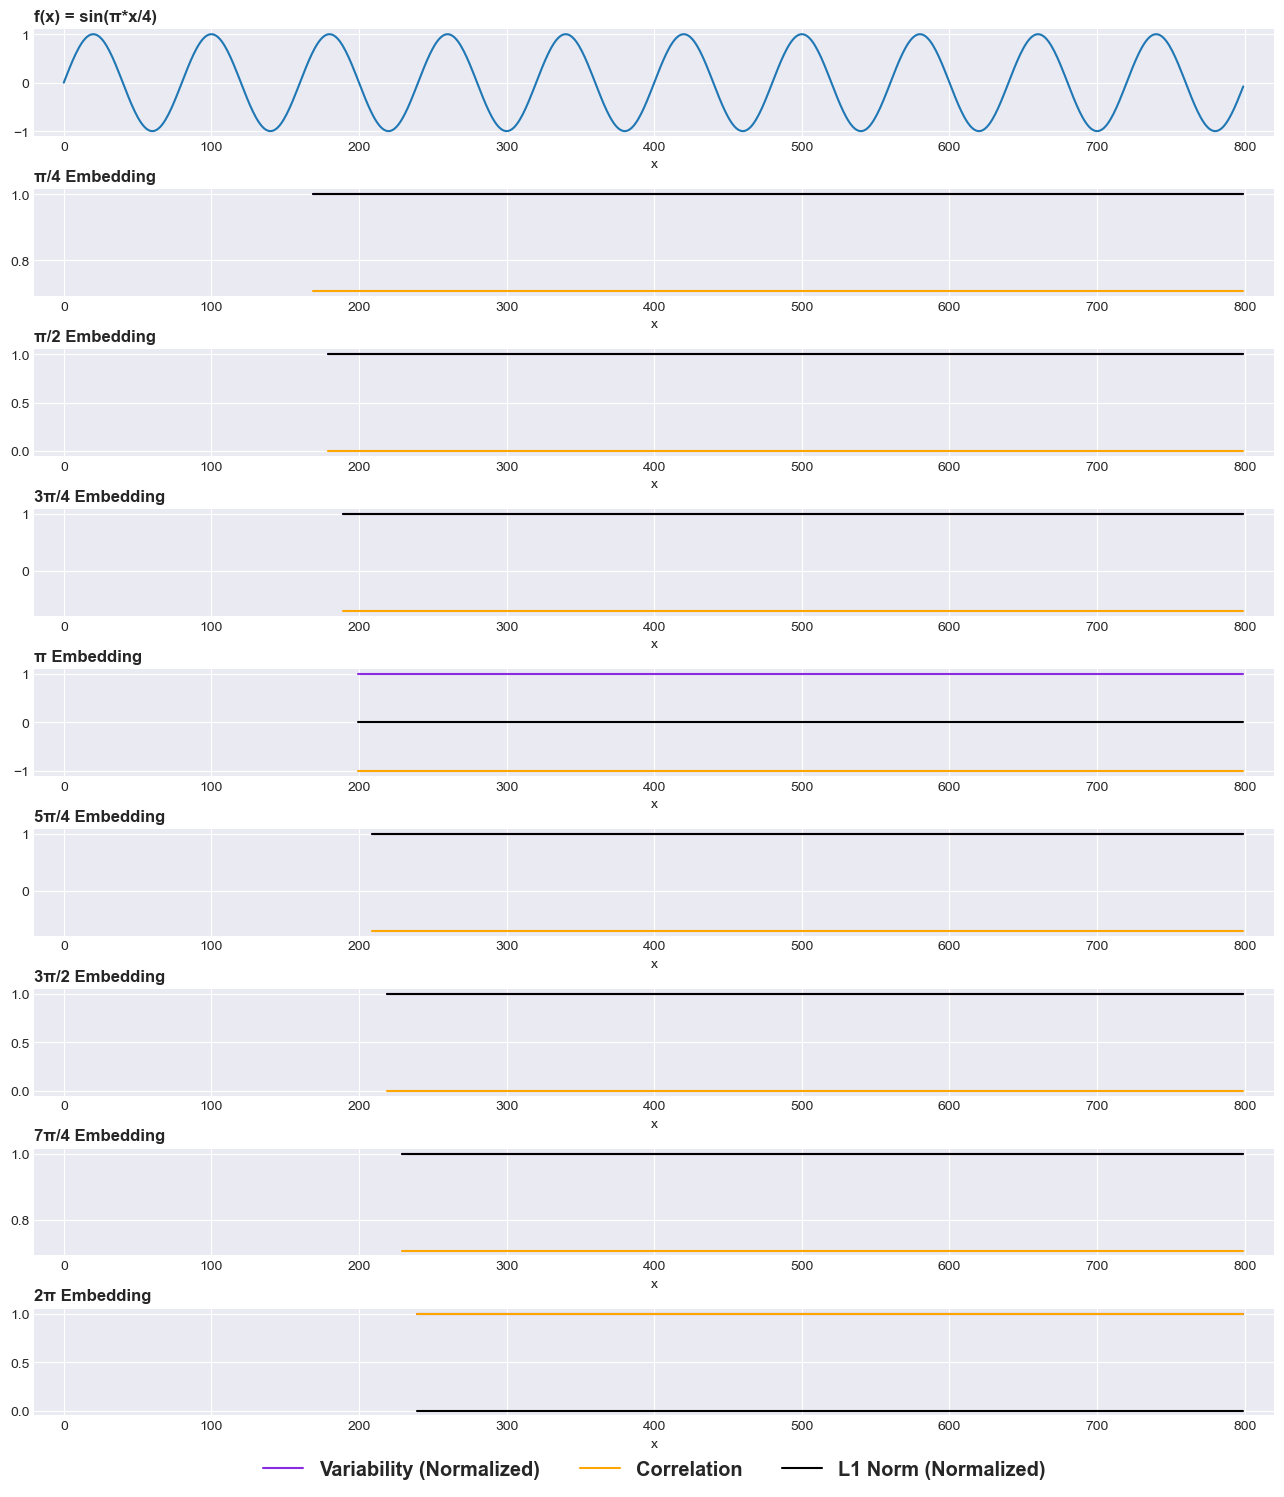

In [6]:
# Create time series
x = np.arange(0, 80, .1)
f1 =  math.pi * (1/4)
np.random.seed(0)
np.random.seed(42)
y1 = (np.sin(f1*x) 
#             + np.random.normal(scale=.1, size=len(x))
)
y1 = np.round(y1, 5)



# TDA Process
avgl1normsnonoise = []
plt.figure(figsize = (16,18))

i = 1
for lag in range(0,170, 10):
    avgl1normsnonoise.append(sweL1(ts = y1, lag = lag, windowsize = 160, landscapelayers = 10))


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=3, prop={'size': 'x-large', 'weight': 'bold'})
plt.show()   
    
    


## XS Noise

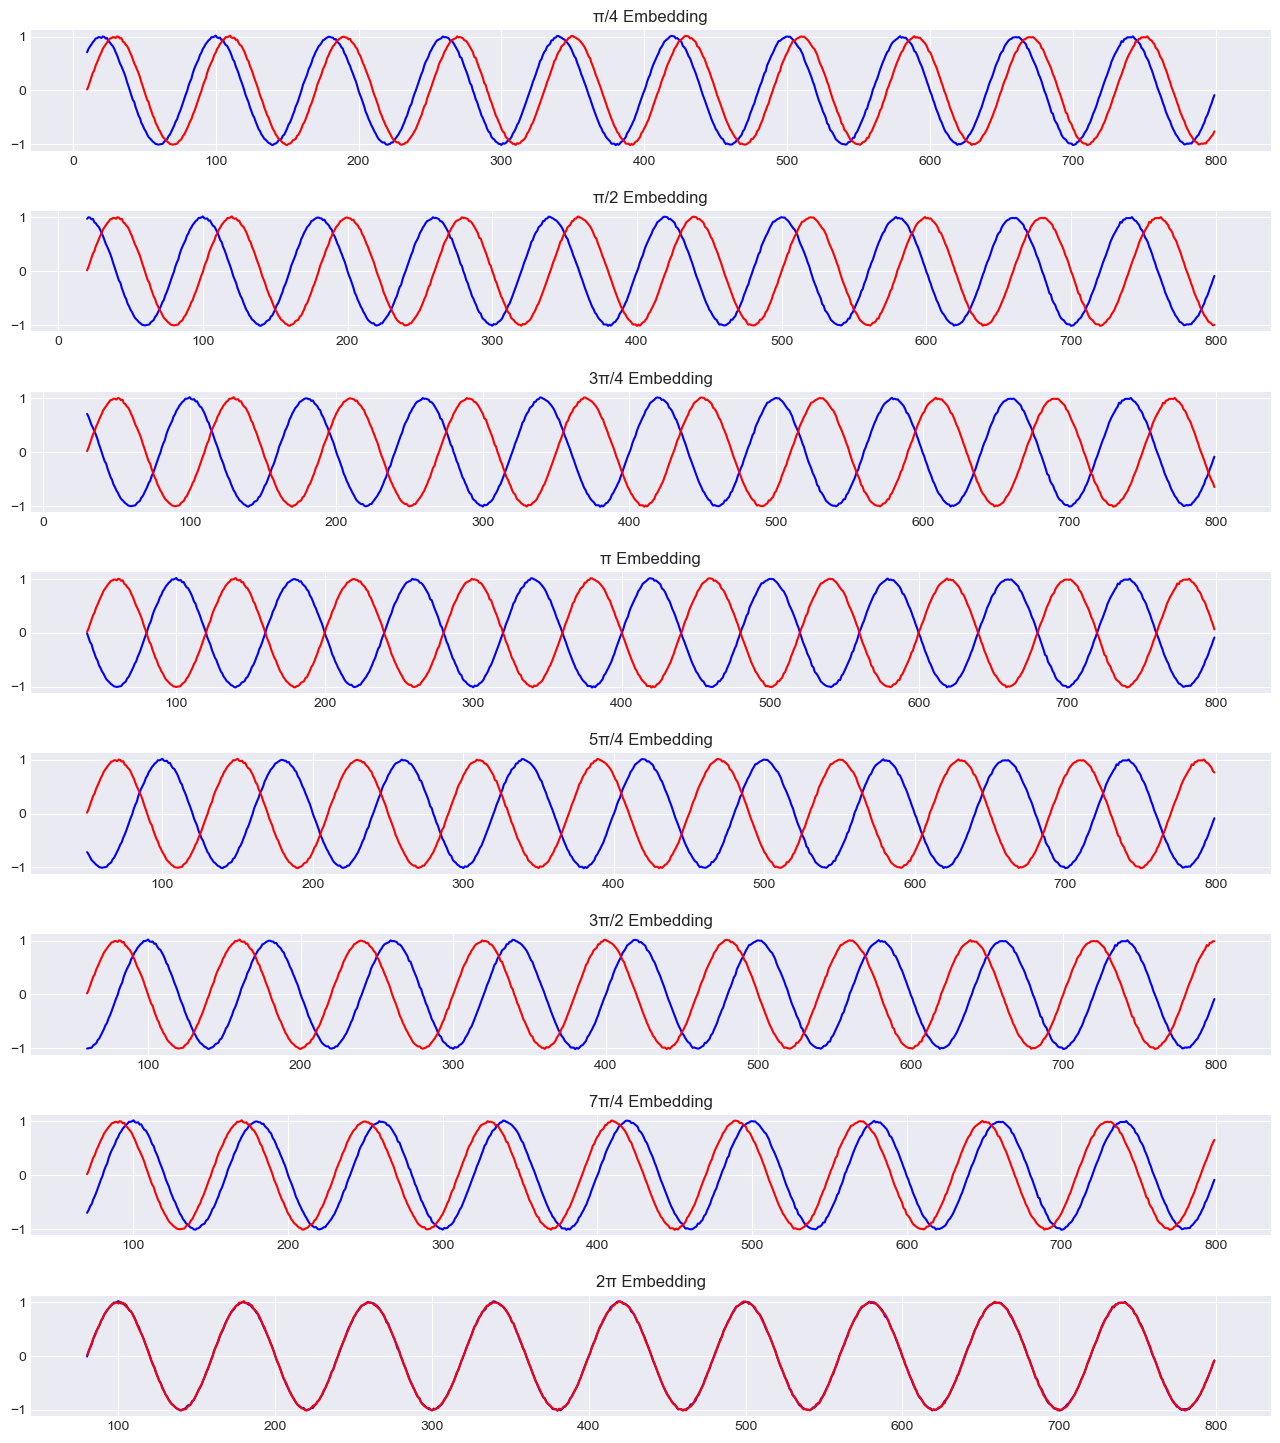

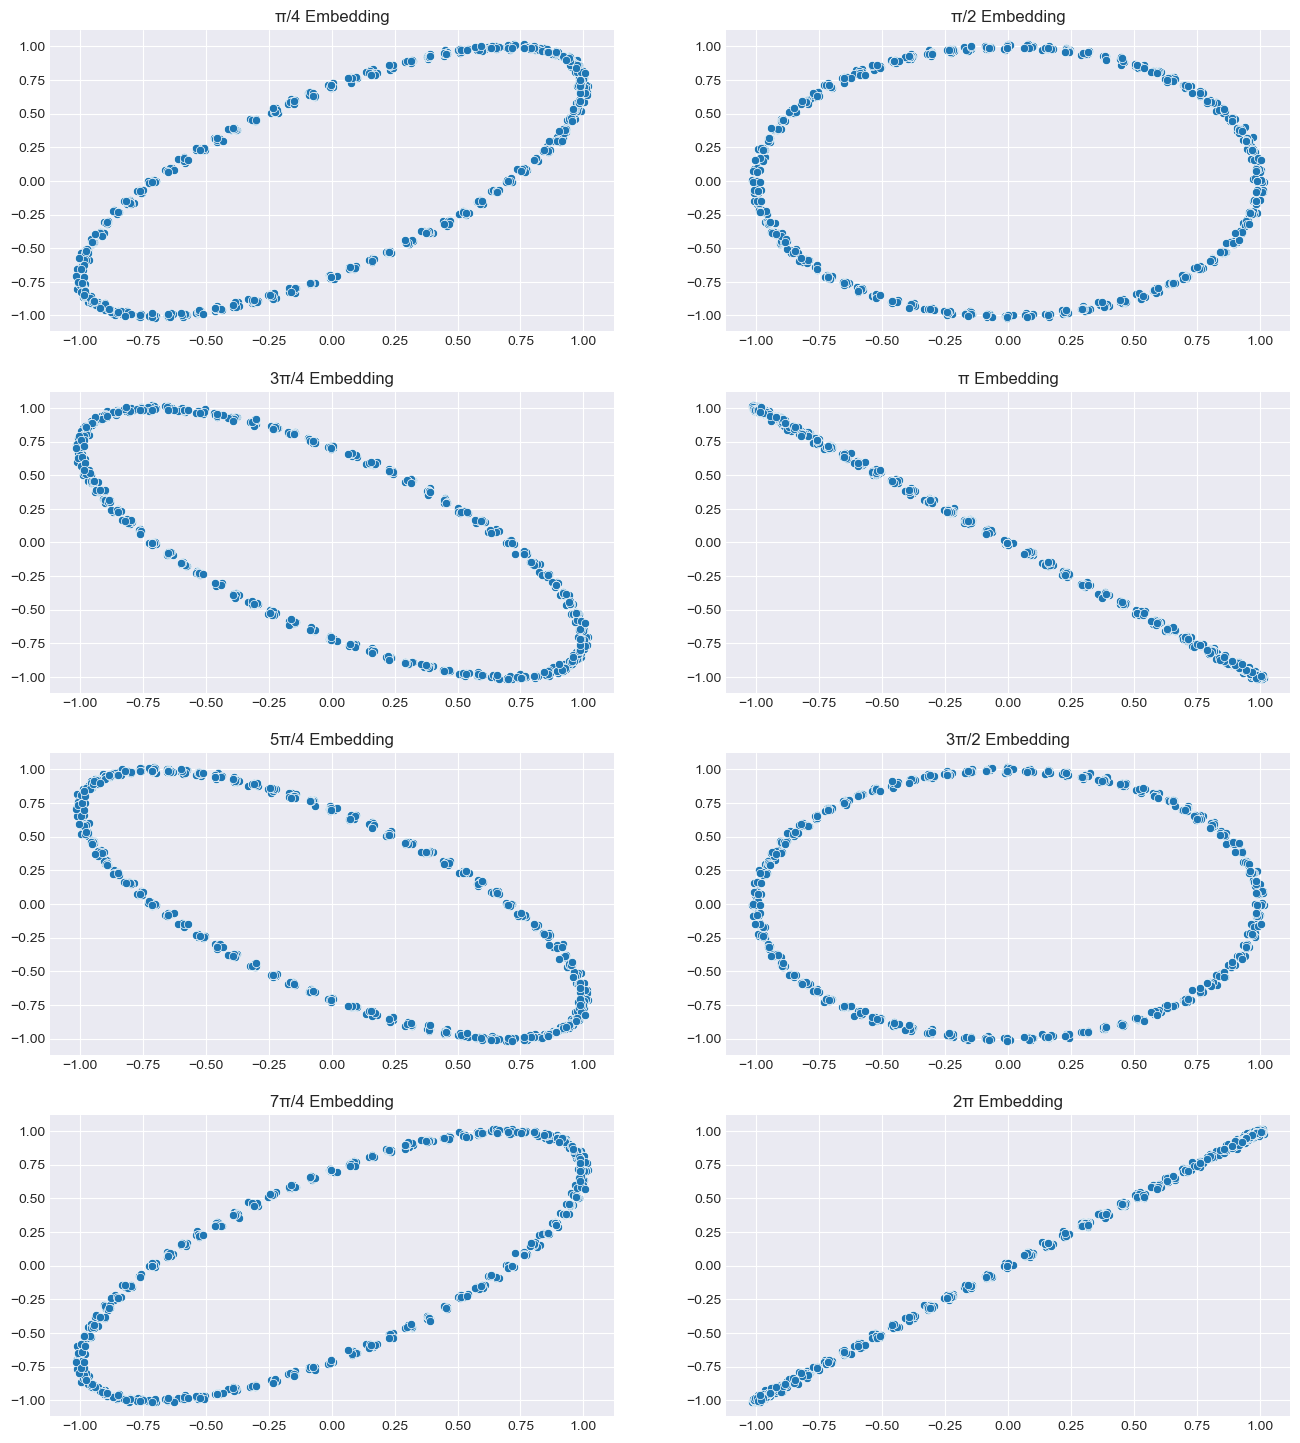

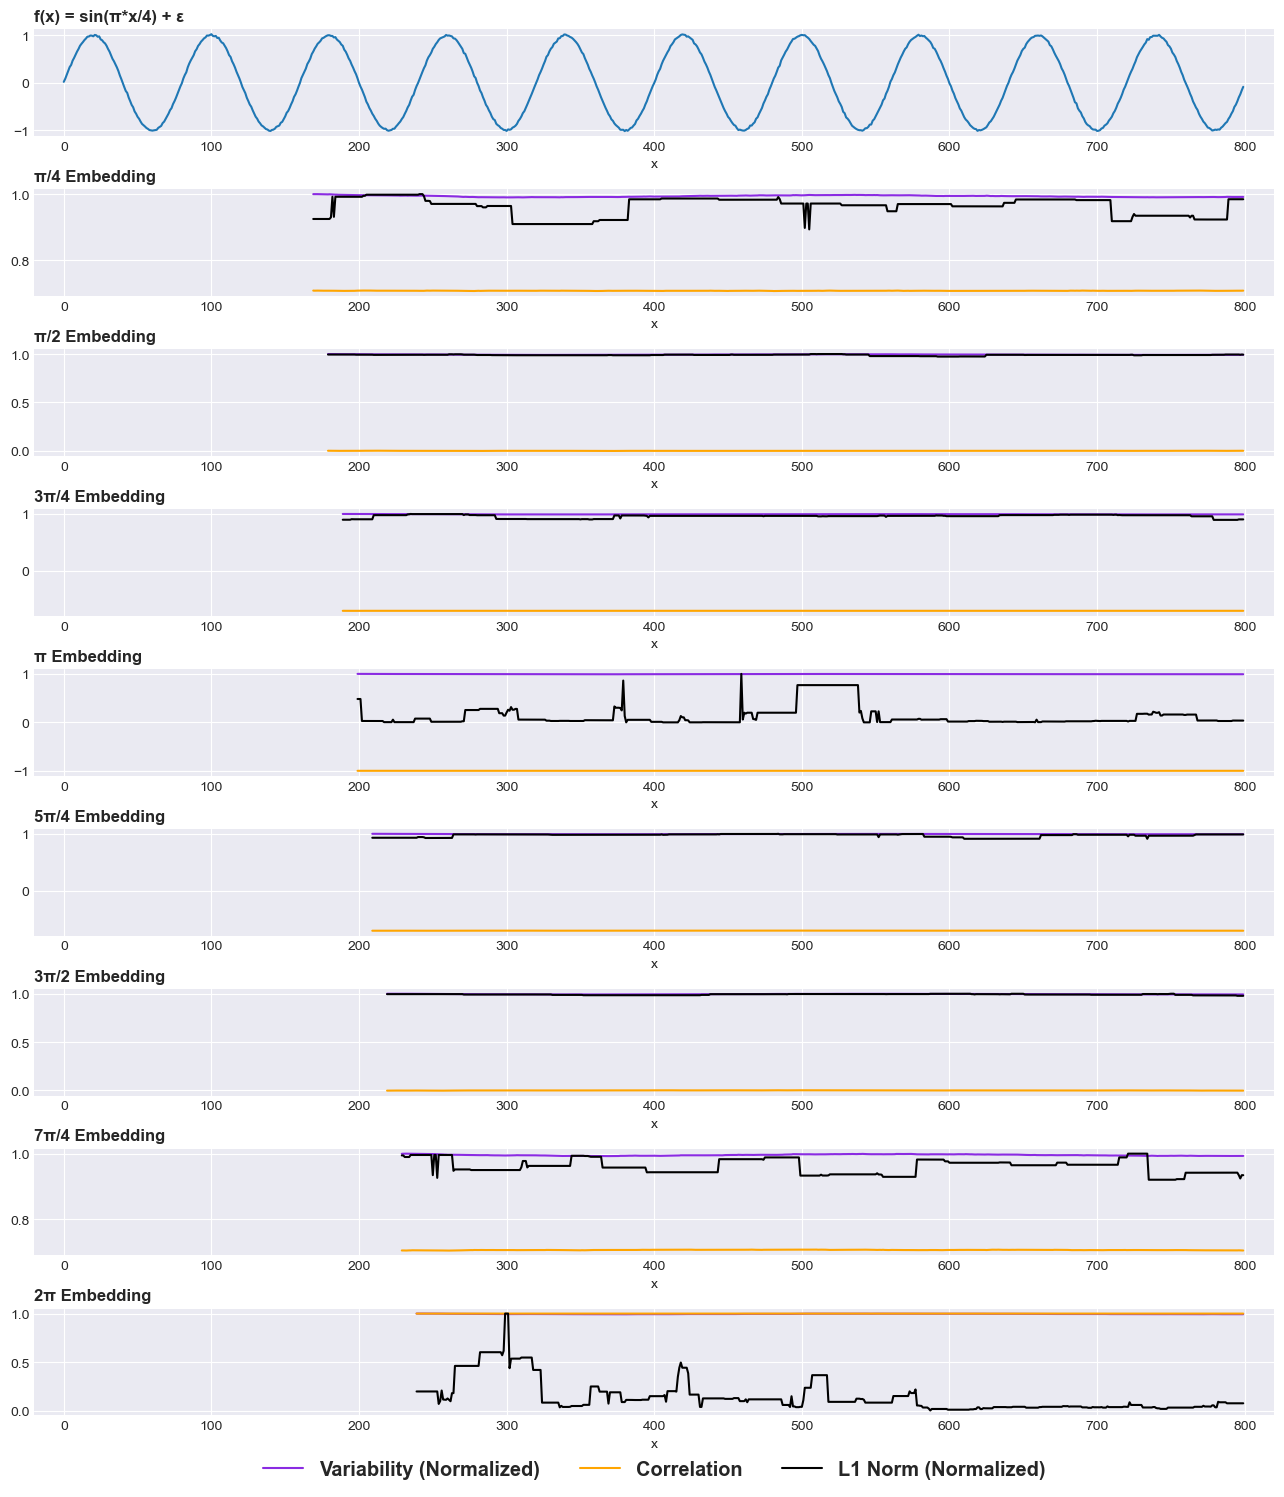

In [7]:
x = np.arange(0, 80, .1)
f1 =  math.pi * (1/4)
np.random.seed(0)
y1 = (np.sin(f1*x) 
            + np.random.normal(scale=.01, size=len(x))

        )
y1 = np.round(y1, 5)


embeddingdemo(ts = y1)



# TDA Process
avgl1normsxsnoise = []
plt.figure(figsize = (16,18))

i = 1
for lag in range(0,170, 10):
    avgl1normsxsnoise.append(sweL1(ts = y1, lag = lag, windowsize = 160, landscapelayers = 10,
                                  functionname = 'f(x) = sin(π*x/4) + ε'))


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=3, prop={'size': 'x-large', 'weight': 'bold'})
plt.show()   

#### Run at lag 1 and lag 79 compare to lag 40 in the case of XS small noise

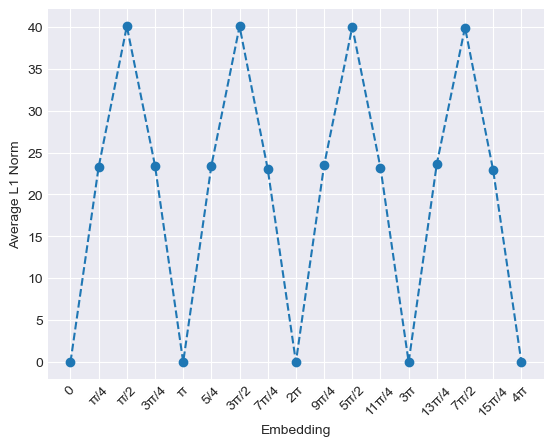

In [8]:
plt.plot(avgl1normsxsnoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
# plt.title('Average L1 Norm vs Phase Shift Embedding - xs Noise')
plt.show()

## Small Noise

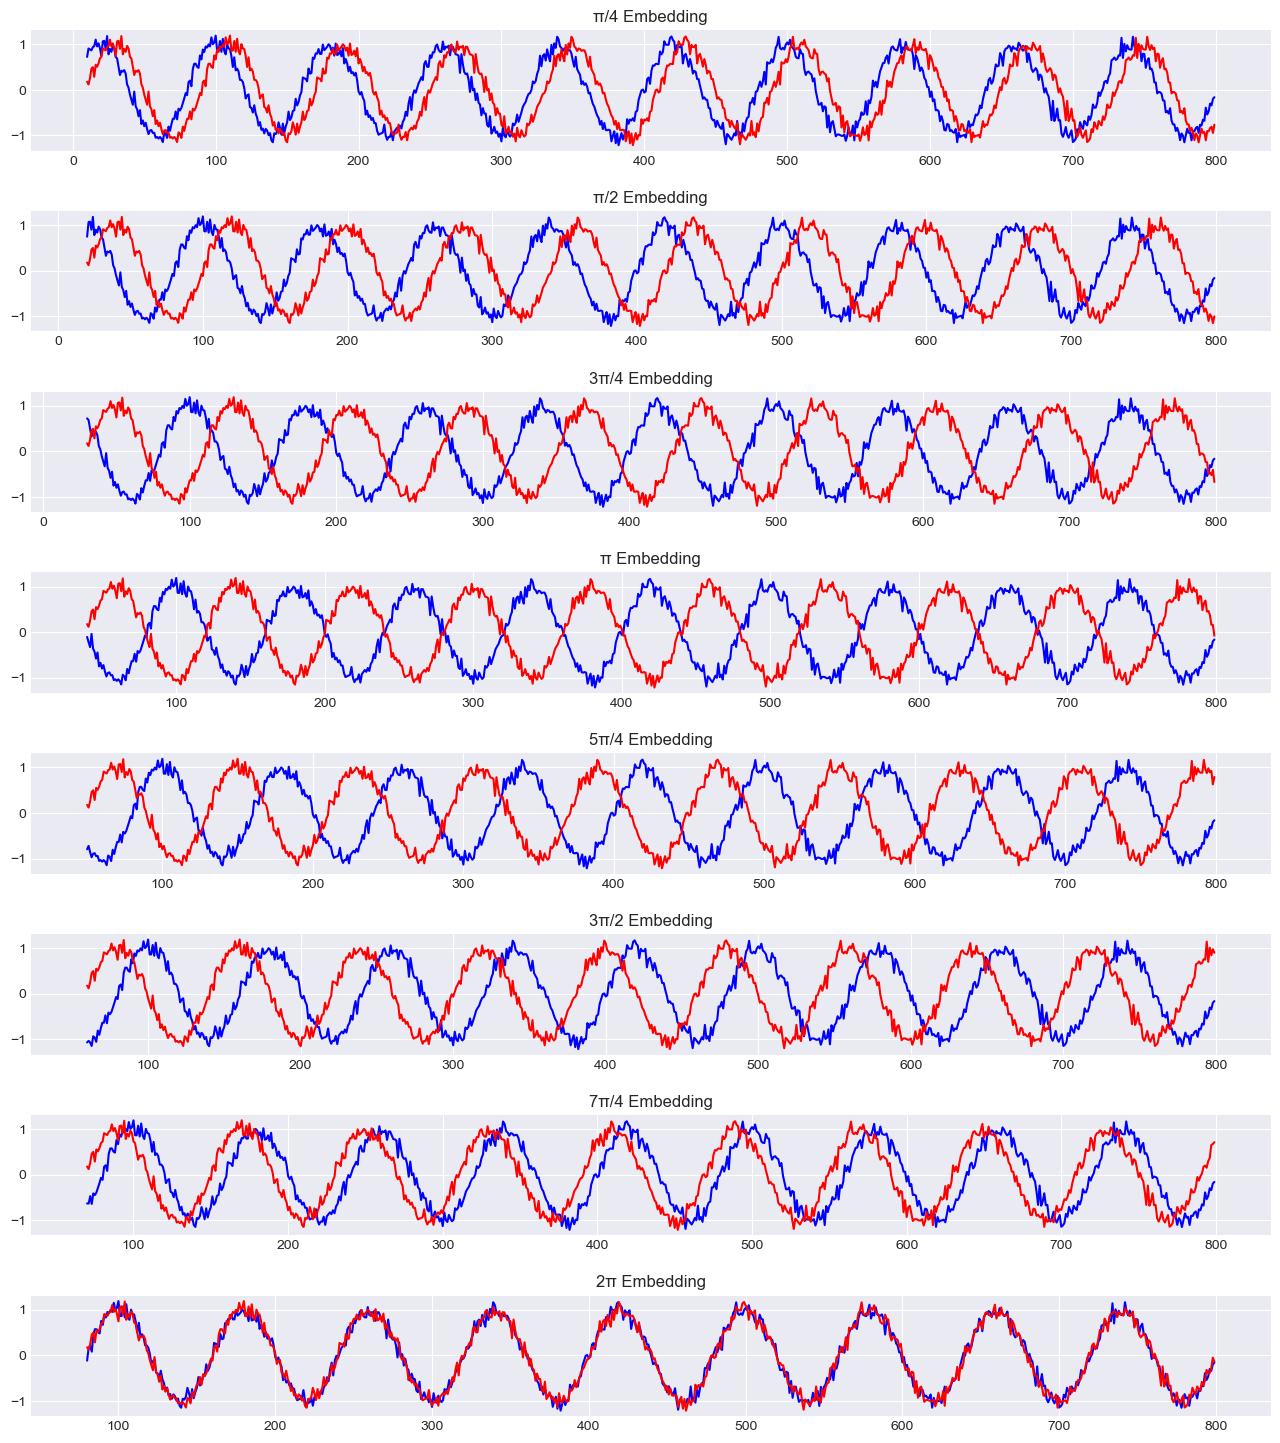

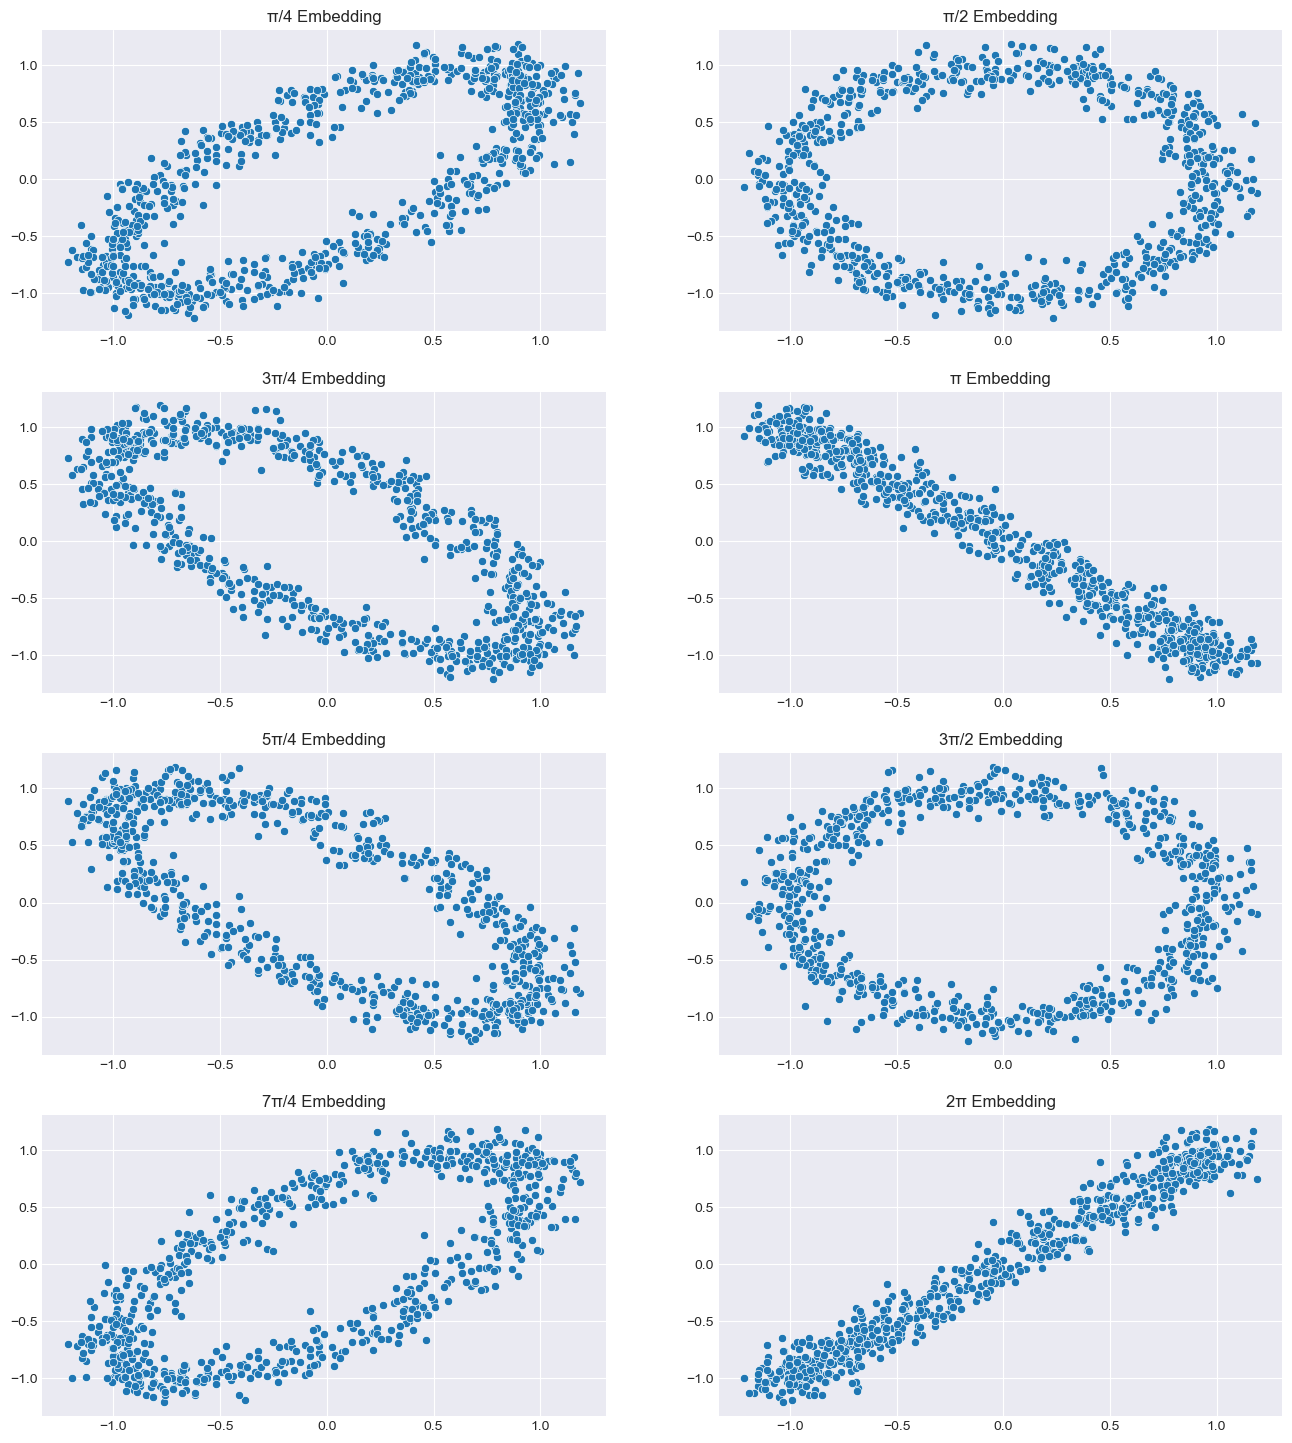

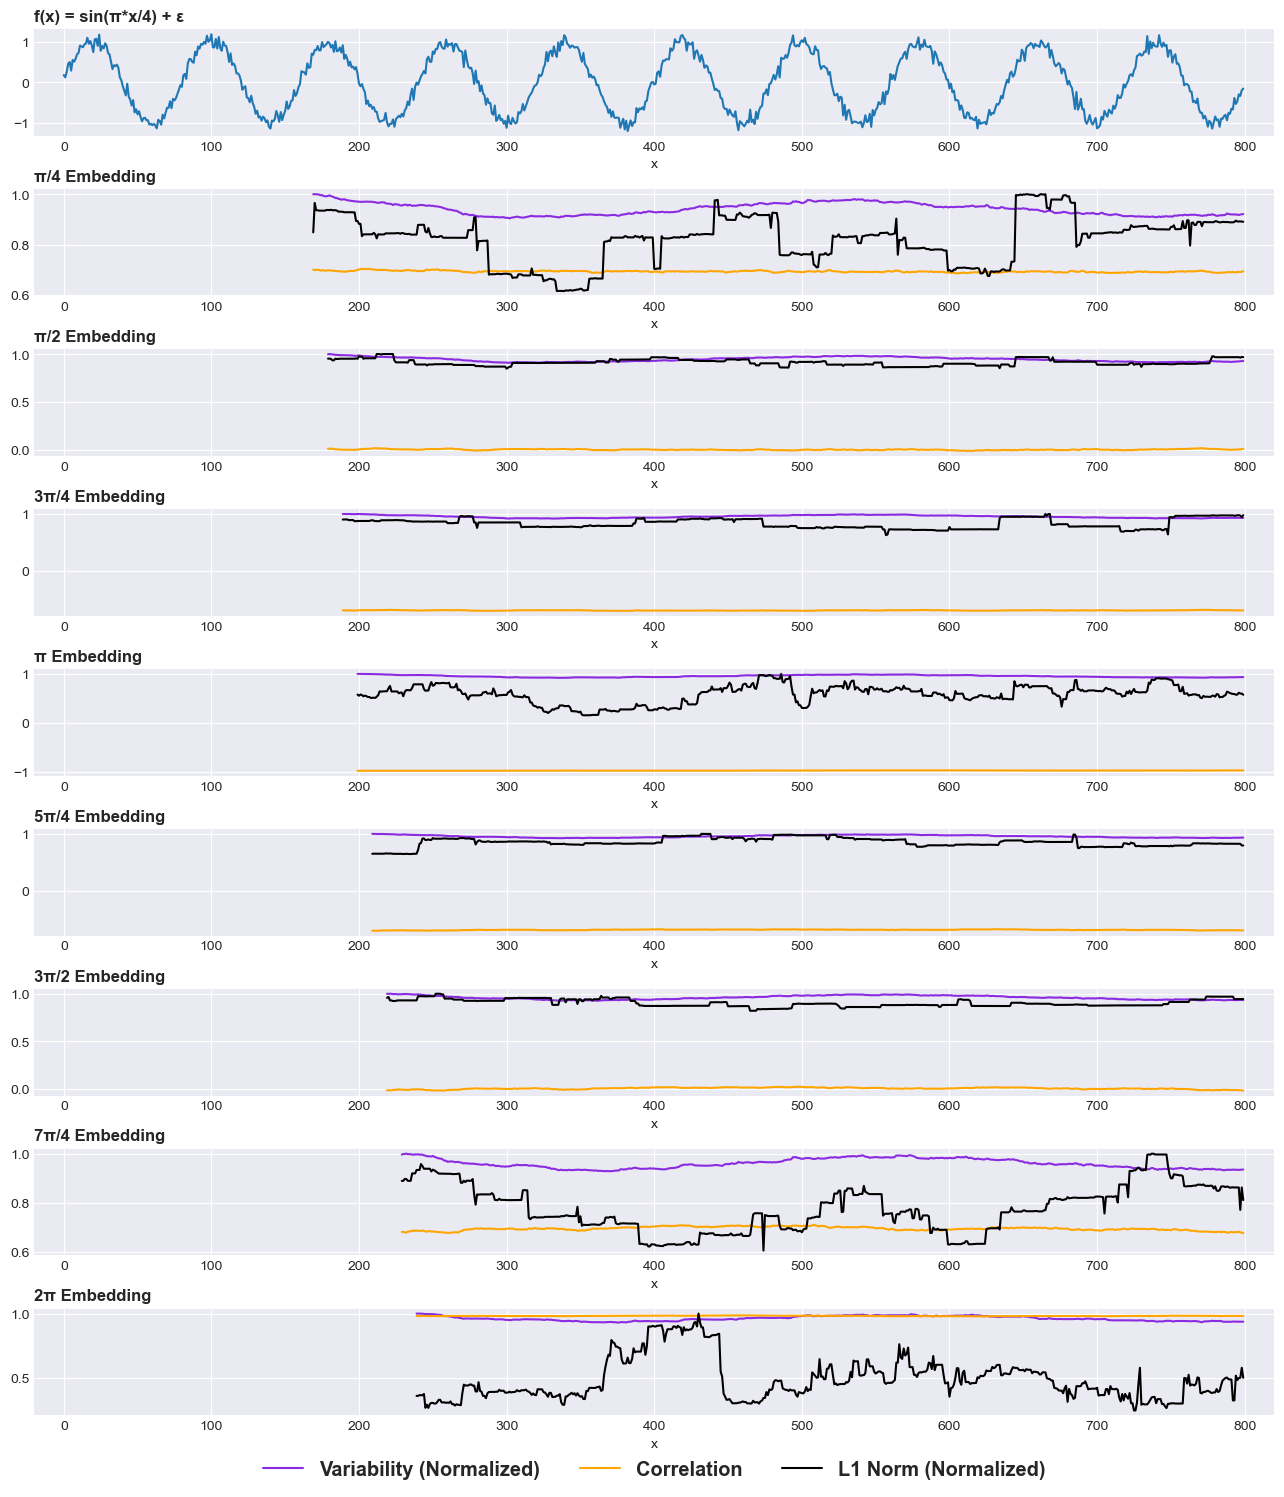

In [14]:
x = np.arange(0, 80, .1)
f1 =  math.pi * (1/4)
np.random.seed(0)
y1 = (np.sin(f1*x) 
            + np.random.normal(scale=.1, size=len(x))

        )
y1 = np.round(y1, 5)

embeddingdemo(ts = y1)

# TDA Process
avgl1normssmallnoise = []
plt.figure(figsize = (16,18))

i = 1
for lag in range(0,170, 10):
    avgl1normssmallnoise.append(sweL1(ts = y1, lag = lag, windowsize = 160, landscapelayers = 10,
                               functionname = 'f(x) = sin(π*x/4) + ε'))


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=3, prop={'size': 'x-large', 'weight': 'bold'})
plt.show()  

### Deep Dive Analysis on Drop in 2pi Embedding

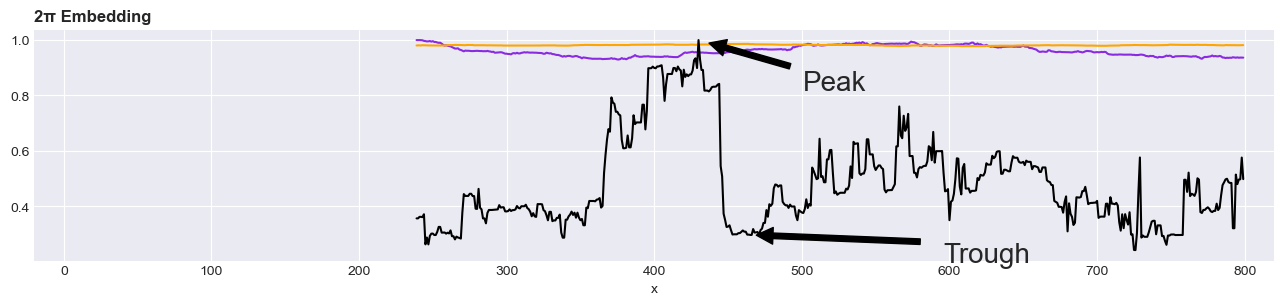

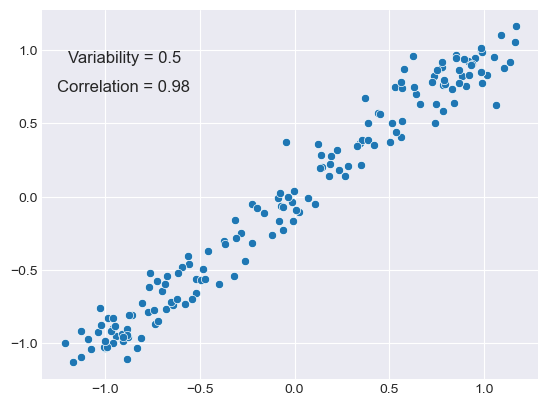

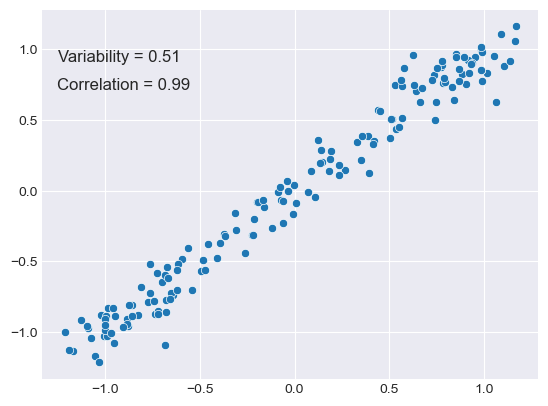

In [15]:
from spectrum import Periodogram
p = Periodogram(y1
#                 , sampling=len(simulated_data1)
               )
p.run()

for lag in range(80,90, 10):
    simulated_data = pd.DataFrame({'Simulated Data 1' : y1
                 })
    simulated_data['Simulated Data 2'] = simulated_data['Simulated Data 1'].shift(lag)
    simulated_data = simulated_data.dropna()

    # Create point cloud
    window_size = 160
    stride = 1
    df = simulated_data
    X = df
    y = df.index
    SW = SlidingWindow(size=window_size, stride=stride)
    X_sw, yr = SW.fit_transform_resample(X, y)

    # Calculate the norms for each of the windows in the multivariate sliding window
    variabilitys = np.empty(window_size -1 + lag)
    variabilitys[:] = np.nan
    variabilitys = list(variabilitys)

    correlations = np.empty(window_size -1 + lag)
    correlations[:] = np.nan
    correlations = list(correlations)
    
    Norms = np.empty(window_size-1 + lag)
    Norms[:] = np.nan
    Norms = list(Norms)
    
    l2Norms = np.empty(window_size-1 + lag)
    l2Norms[:] = np.nan
    l2Norms = list(l2Norms)
    
    layers = 10
    vrp = VietorisRipsPersistence()
    pl = PersistenceLandscape(layers)
    for pointcloud in X_sw:
        persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
        landscapedata = pl.fit_transform(persistencediagram)
        tseq = Ftseq(persistencediagram[0])
        Norms.append(Lpnorm(tseq, landscapedata[0], p = 1))    
        l2Norms.append(Lpnorm(tseq, landscapedata[0], p = 2))
    
        pointcloudcovmatrix = np.array(pd.DataFrame(pointcloud).cov())
        variabilitys.append((pointcloudcovmatrix[0][0]  + pointcloudcovmatrix[1][1]) / 2)
    
        pointcloudcorrmatrix = np.array(pd.DataFrame(pointcloud).corr())
        correlations.append(np.round(pointcloudcorrmatrix[0][1], 5))

    simulateddata1normalized = simulated_data['Simulated Data 1']/simulated_data['Simulated Data 1'].max()
    simulateddata2normalized = simulated_data['Simulated Data 2']/simulated_data['Simulated Data 2'].max()
    Norms = np.array(Norms) / pd.Series(Norms).max() if pd.Series(Norms).max() != 0 else np.array(Norms)*0
    l2Norms = np.array(l2Norms) / pd.Series(l2Norms).max() if pd.Series(l2Norms).max() != 0 else np.array(l2Norms)*0
    variabilitys = np.array(variabilitys) / pd.Series(variabilitys).max() if pd.Series(variabilitys).max() != 0 else np.array(variabilitys)*0
    maxcorr = pd.Series(correlations).max() 
    #     correlations = np.array(correlations) / pd.Series(correlations).max() if pd.Series(correlations).max() != 0 else np.array(correlations)*0
    
    plt.figure(figsize = (16,3))
    plt.style.use('seaborn-darkgrid')
    plt.subplots_adjust(hspace=.5)
    plt.plot(variabilitys, color = 'blueviolet', label = 'Variability (Normalized)')
    #     corrlabel = 'Correlation' if maxcorr >= 0 else 'Correlation (Negative)'
    corrlabel = 'Correlation'
    plt.plot(correlations, color = 'orange', label = corrlabel)
    plt.plot(Norms, color = 'black', label = 'L1 Norm (Normalized)')
    plt.title('2π' + ' Embedding', fontweight = 'bold', loc='left')
    plt.xlabel('x')
    plt.xlim([-20,820])
    plt.annotate('Peak', 
            xy=(430, Norms[430]),
            xycoords= 'data',
            xytext=(444+ 100, Norms[444] + .05), 
    #             textcoords=’axes fraction’,
            arrowprops=dict(facecolor= 'black'
                            , shrink=0.1
                           ),
            horizontalalignment='right',
            verticalalignment= 'top',
            size = 20)

    plt.annotate('Trough', 
                xy=(455, Norms[455]),
                xycoords= 'data',
                xytext=(455 + 200, Norms[455]-.03), 
    #             textcoords=’axes fraction’,
                arrowprops=dict(facecolor= 'black', shrink=0.1),
                horizontalalignment='right',
                verticalalignment= 'top',
                size = 20)



# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
#           fancybox=True, shadow=True, ncol=3, prop={'size': 'x-large', 'weight': 'bold'})
plt.show() 



################### Plot the persistence diagram and landscape for point 430#####################
index = 191
sns.scatterplot(X_sw[index][:,0], X_sw[index][:,1])
plt.annotate('Correlation = ' + str(round(np.corrcoef(X_sw[index][:,0], X_sw[index][:,1])[0,1], 2)), 
        xy=(-.55, .8),
        xycoords= 'data',
#         xytext=(444+ 100, Norms[444] + .05), 
#             textcoords=’axes fraction’,
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.annotate('Variability = ' + str(round((np.var(X_sw[index][:,0]) + np.var(X_sw[index][:,1])) / 2, 2)), 
        xy=(-.6, 1),
        xycoords= 'data',
#         xytext=(444+ 100, Norms[444] + .05), 
#             textcoords=’axes fraction’,
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)



plt.show()


from gtda.homology import VietorisRipsPersistence
from plotly.subplots import make_subplots
pointcloud = X_sw[index]

fig = make_subplots(rows=1, cols=2)
vrp = VietorisRipsPersistence()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape), plotly_params = dict(row=1, col=2))



layers = 5
pl = PersistenceLandscape(layers)
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
pl.plot(landscapedata, 
        homology_dimensions = [1], 
        plotly_params = dict(row=2, col=2))




################### Plot the persistence diagram and landscape for trough point #####################
index = 226
sns.scatterplot(X_sw[index][:,0], X_sw[index][:,1])
plt.plot(label = 'test')
plt.annotate('Correlation = ' + str(round(np.corrcoef(X_sw[index][:,0], X_sw[index][:,1])[0,1], 2)), 
        xy=(-.55, .8),
        xycoords= 'data',
#         xytext=(444+ 100, Norms[444] + .05), 
#             textcoords=’axes fraction’,
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.annotate('Variability = ' + str(round((np.var(X_sw[index][:,0]) + np.var(X_sw[index][:,1])) / 2, 2)), 
        xy=(-.6, 1),
        xycoords= 'data',
#         xytext=(444+ 100, Norms[444] + .05), 
#             textcoords=’axes fraction’,
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.show()

from gtda.homology import VietorisRipsPersistence
from plotly.subplots import make_subplots
pointcloud = X_sw[index]

fig = make_subplots(rows=1, cols=2)
vrp = VietorisRipsPersistence()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape), plotly_params = dict(row=1, col=2))



layers = 5
pl = PersistenceLandscape(layers)
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
pl.plot(landscapedata, 
        homology_dimensions = [1], 
        plotly_params = dict(row=2, col=2))
    
    

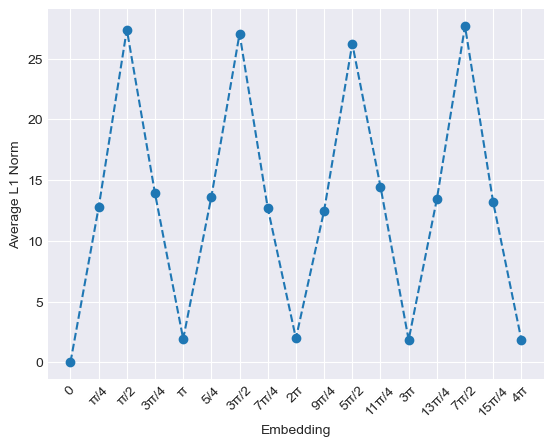

In [16]:
plt.plot(avgl1normssmallnoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.show()

## Moderate Noise

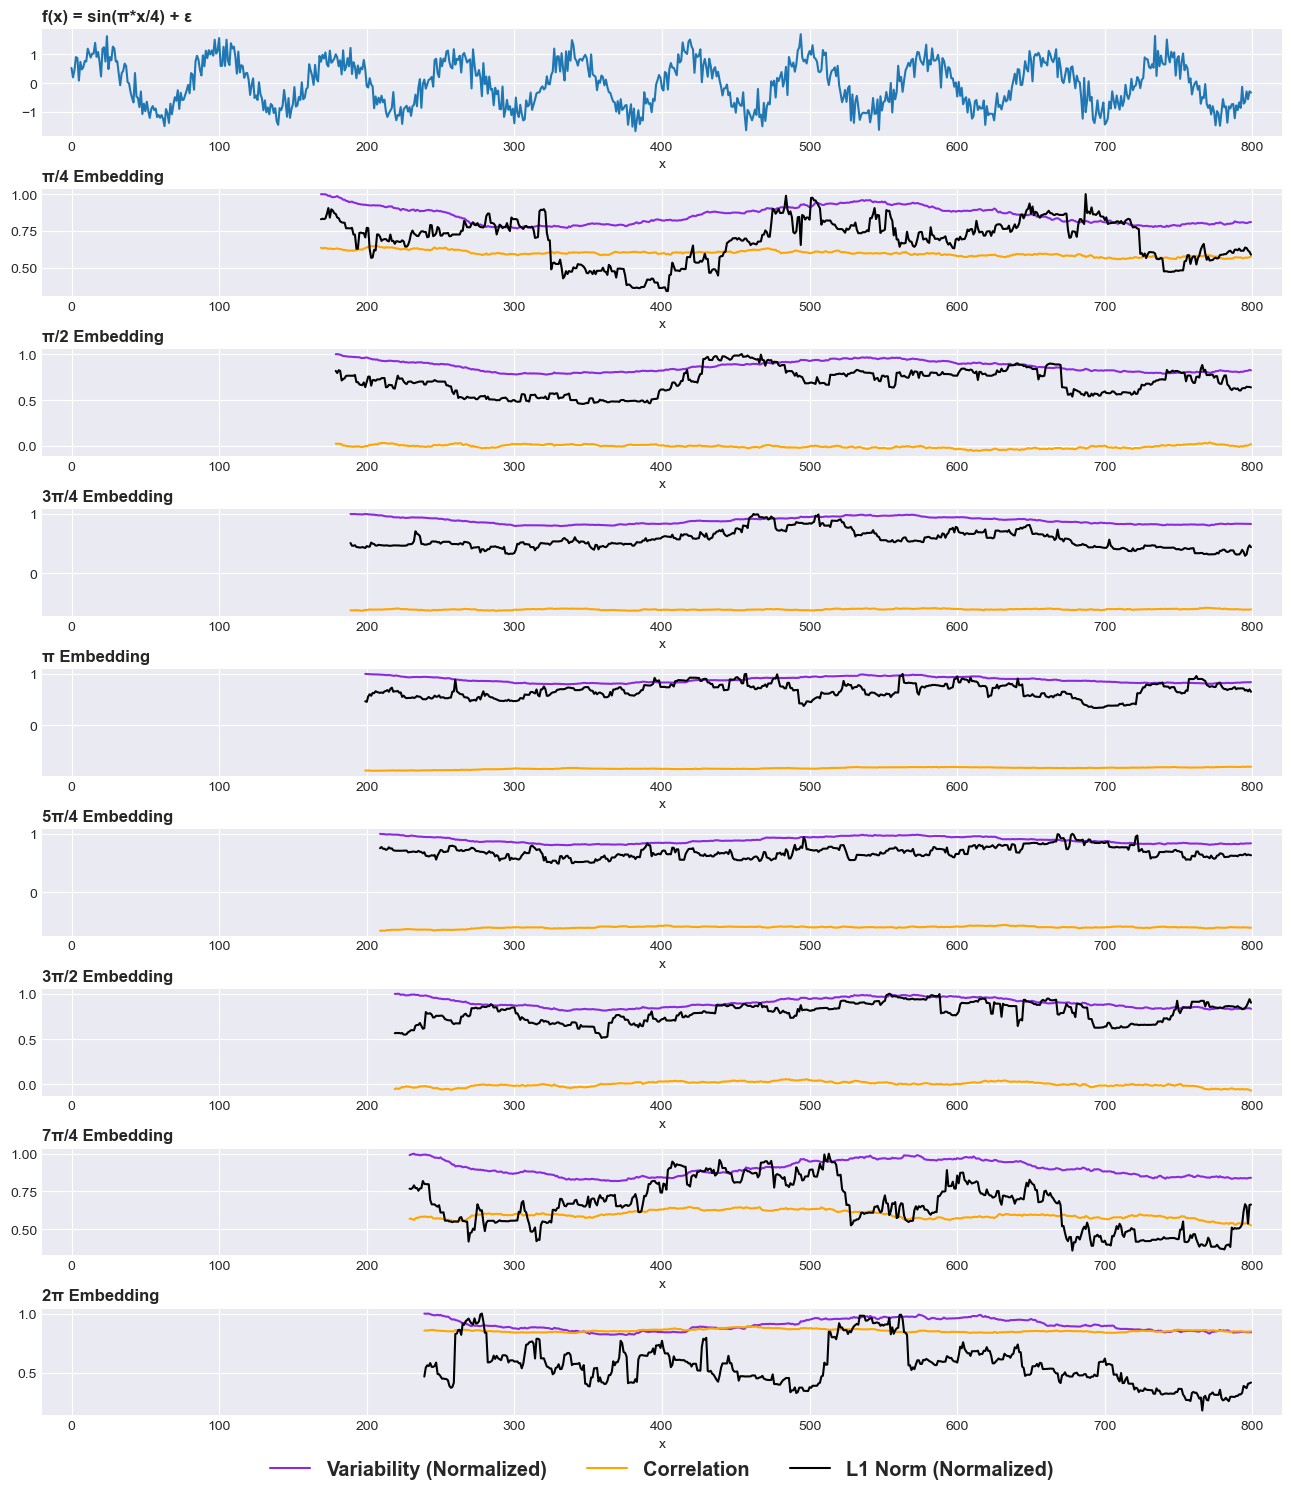

In [17]:
x = np.arange(0, 80, .1)
f1 =  math.pi * (1/4)
np.random.seed(0)
y1 = (np.sin(f1*x) 
            + np.random.normal(scale=.3, size=len(x))

        )
y1 = np.round(y1, 5)

# embeddingdemo(ts = y1)

# TDA Process
avgl1normsmoderatenoise = []
plt.figure(figsize = (16,18))

i = 1
for lag in range(0,170, 10):
    avgl1normsmoderatenoise.append(sweL1(ts = y1, lag = lag, windowsize = 160, landscapelayers = 10, 
                                         functionname = 'f(x) = sin(π*x/4) + ε'))


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=3, prop={'size': 'x-large', 'weight': 'bold'})
plt.show()  

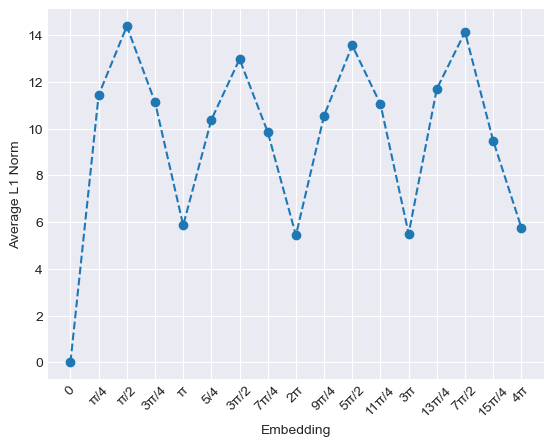

In [18]:
plt.plot(avgl1normsmoderatenoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.show()

## Large Noise

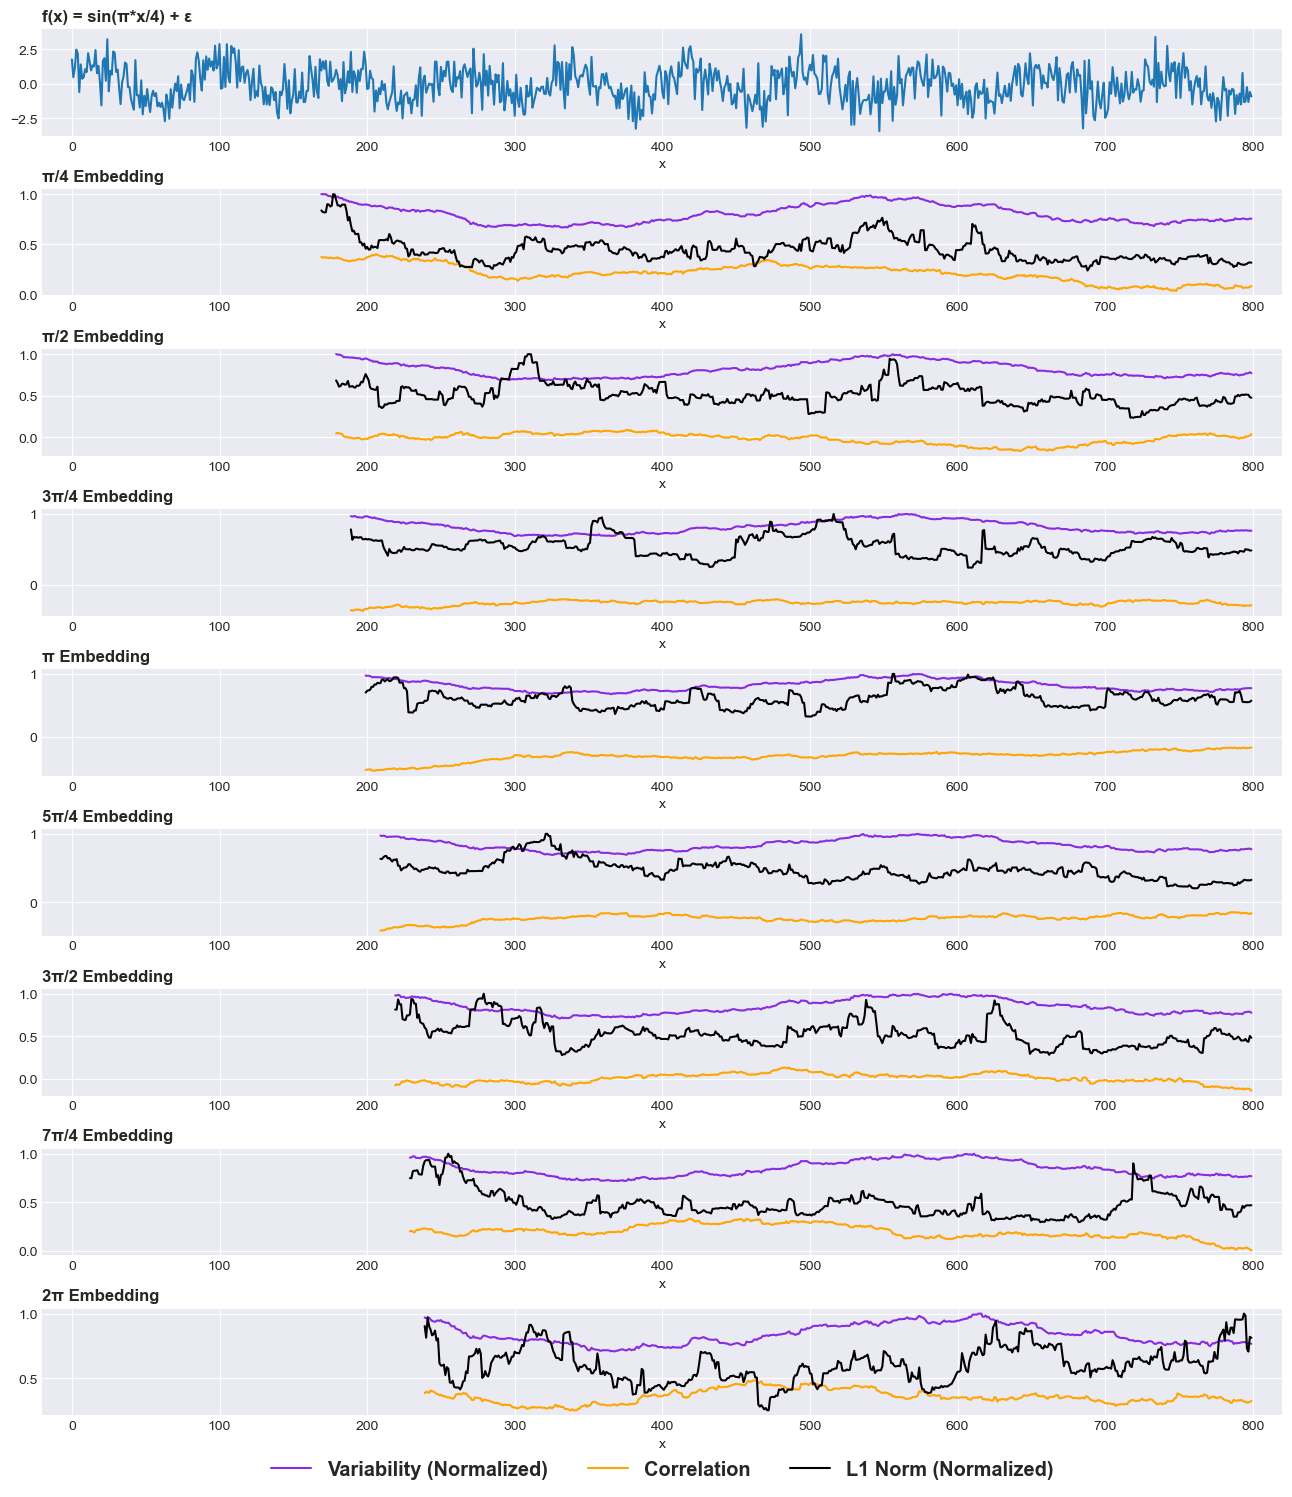

In [19]:
x = np.arange(0, 80, .1)
f1 =  math.pi * (1/4)
np.random.seed(0)
y1 = (np.sin(f1*x) 
            + np.random.normal(scale=1, size=len(x))

        )
y1 = np.round(y1, 5)

# embeddingdemo(ts = y1)

# TDA Process
avgl1normslargenoise = []
plt.figure(figsize = (16,18))

i = 1
for lag in range(0,170, 10):
    avgl1normslargenoise.append(sweL1(ts = y1, lag = lag, windowsize = 160, landscapelayers = 10, 
                                         functionname = 'f(x) = sin(π*x/4) + ε'))


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=3, prop={'size': 'x-large', 'weight': 'bold'})
plt.show()  

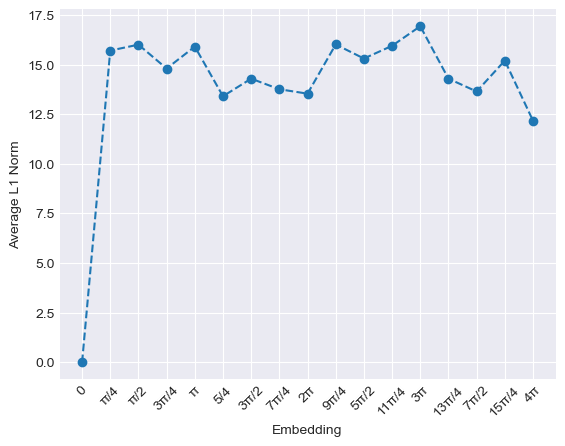

In [20]:
# plt.plot(avgl1normslargenoise,linestyle='dashed', marker='o')
plt.plot(avgl1normslargenoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.show()

## XLarge Noise

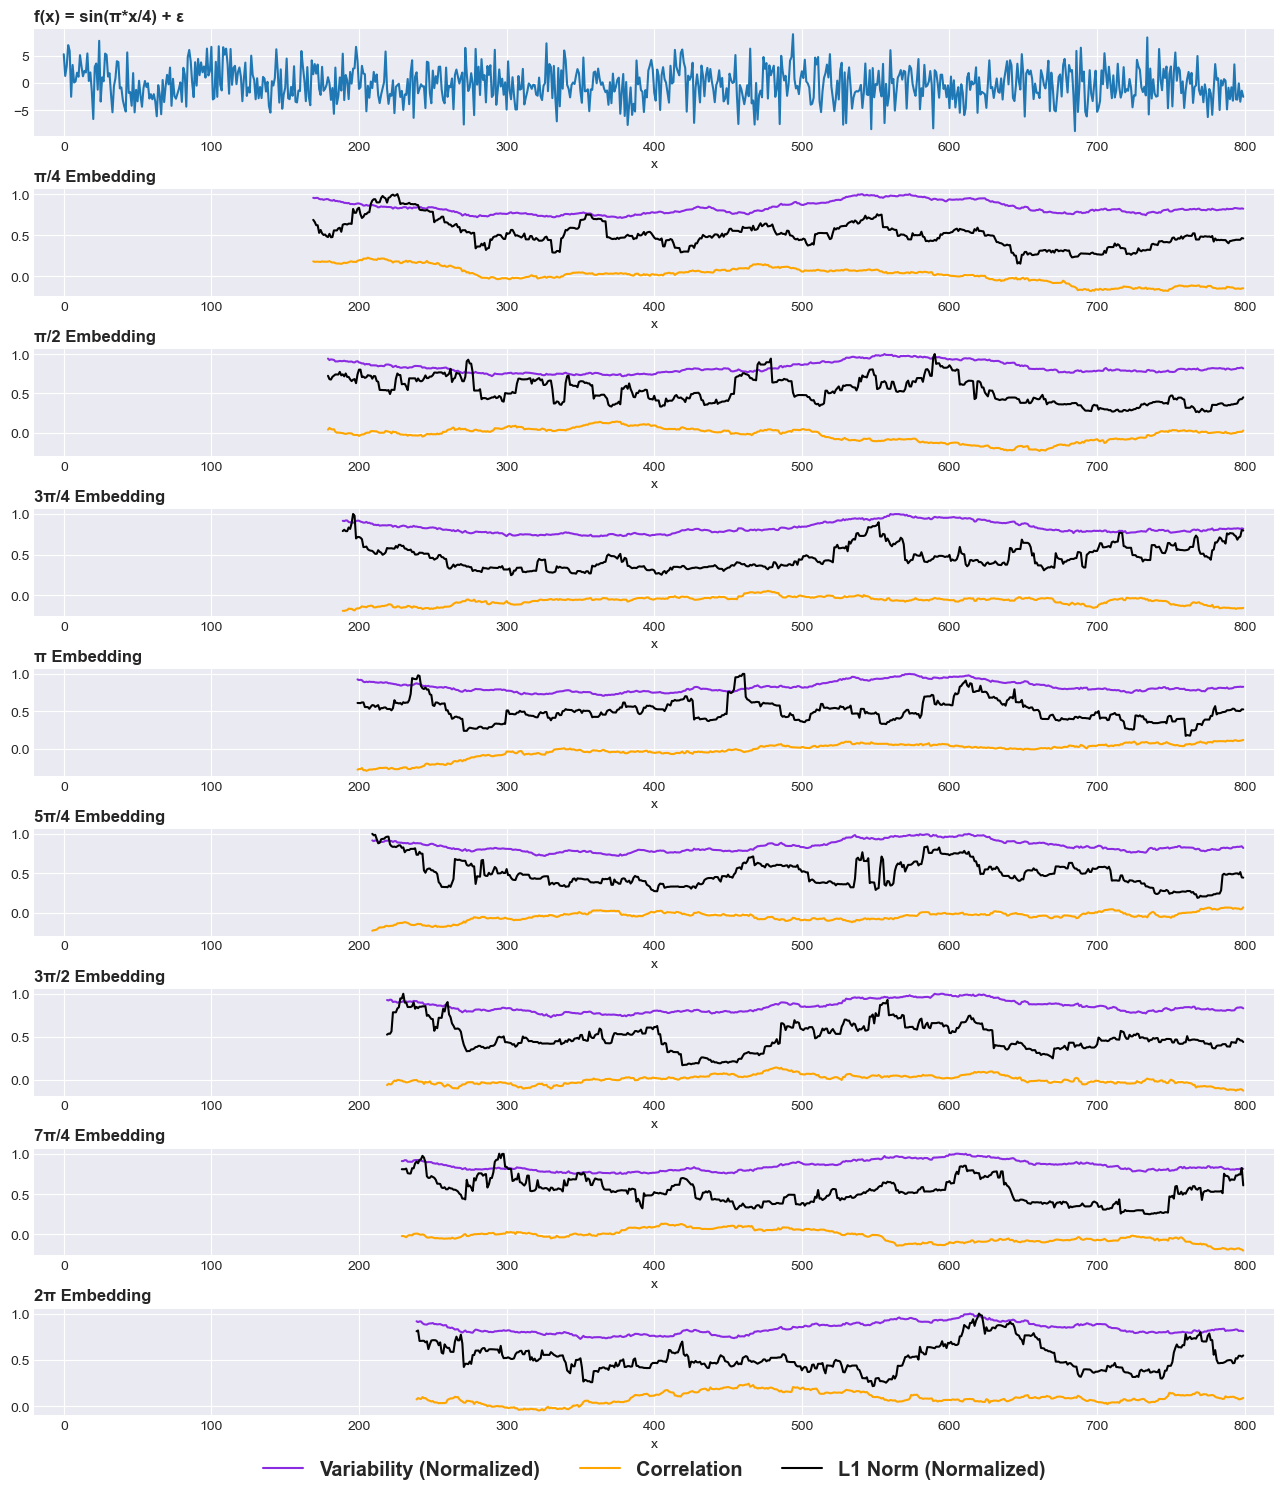

In [21]:
x = np.arange(0, 80, .1)
f1 =  math.pi * (1/4)
np.random.seed(0)
y1 = (np.sin(f1*x) 
            + np.random.normal(scale=3, size=len(x))

        )
y1 = np.round(y1, 5)

# embeddingdemo(ts = y1)

# TDA Process
avgl1normsxlnoise = []
plt.figure(figsize = (16,18))

i = 1
for lag in range(0,170, 10):
    avgl1normsxlnoise.append(sweL1(ts = y1, lag = lag, windowsize = 160, landscapelayers = 10, 
                                         functionname = 'f(x) = sin(π*x/4) + ε'))


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=3, prop={'size': 'x-large', 'weight': 'bold'})
plt.show()  

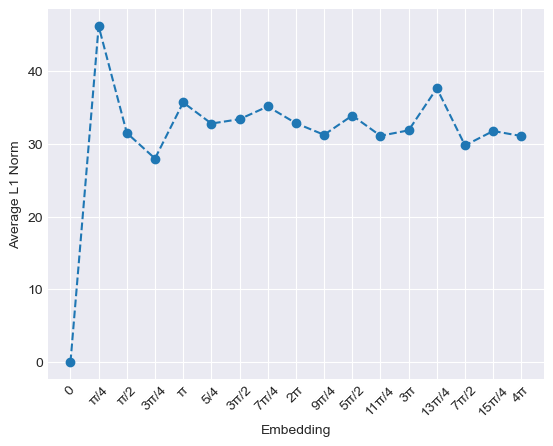

In [22]:
# plt.plot(avgl1normslargenoise,linestyle='dashed', marker='o')
plt.plot(avgl1normsxlnoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.show()

## Putting All Together

Text(0.5, 1.0, 'XL Noise: N~(0,3)')

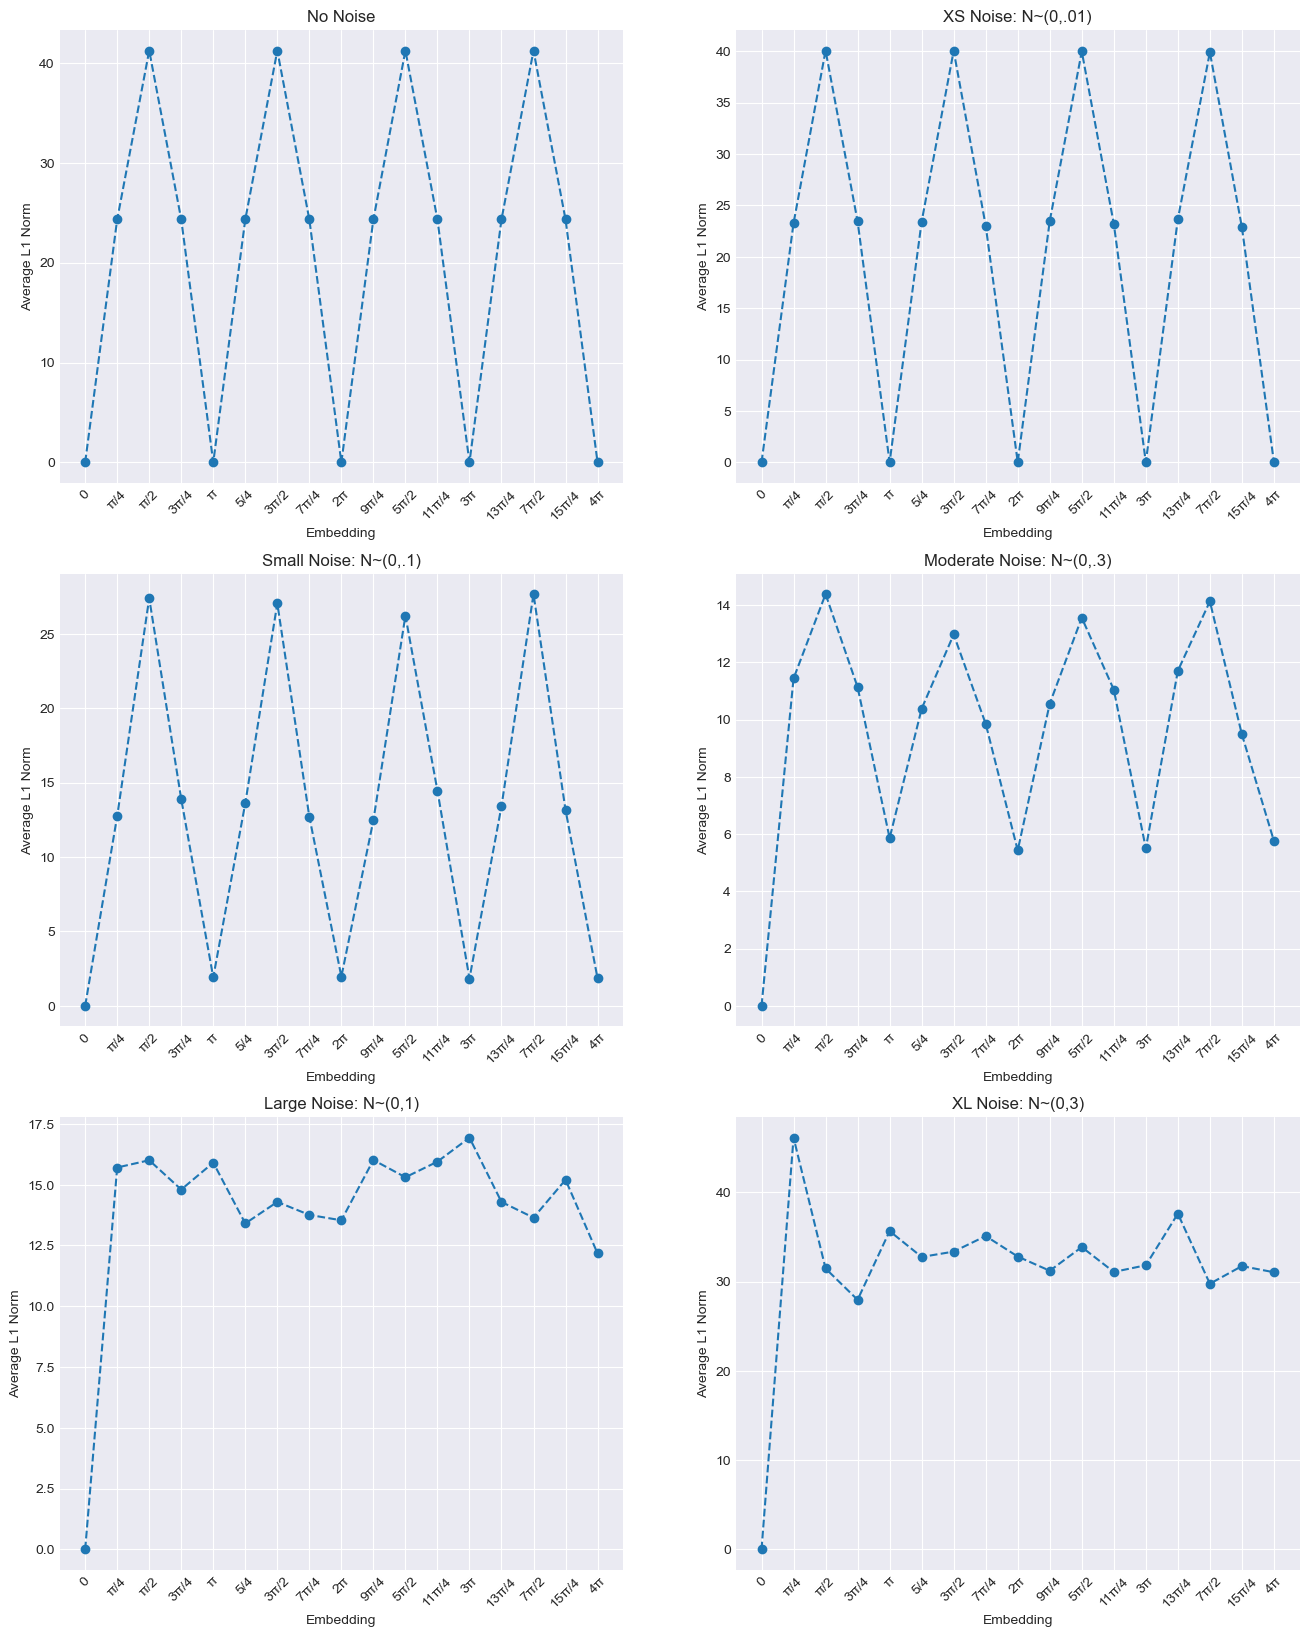

In [23]:
plt.figure(figsize = (16,20))
# plt.suptitle('Average L1 Norm vs Phase Shift Embedding', fontweight="bold")
plt.subplot(3,2,1)
plt.plot(avgl1normsnonoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
plt.title('No Noise')

plt.subplot(3,2,2)
plt.plot(avgl1normsxsnoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
plt.title('XS Noise: N~(0,.01)')

plt.subplot(3,2,3)
plt.plot(avgl1normssmallnoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
plt.title('Small Noise: N~(0,.1)')

plt.subplot(3,2,4)
plt.plot(avgl1normsmoderatenoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
plt.title('Moderate Noise: N~(0,.3)')


plt.subplot(3,2,5)
plt.plot(avgl1normslargenoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
plt.title('Large Noise: N~(0,1)')

plt.subplot(3,2,6)
plt.plot(avgl1normsxlnoise,linestyle='dashed', marker='o')
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.xlabel('Embedding')
plt.ylabel('Average L1 Norm')
plt.title('XL Noise: N~(0,3)')

In [24]:
X = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
Y = [0, .01, .1, .3, 1, 3]
X, Y = np.meshgrid(X,Y)
X.shape


Z = []
Z.append(avgl1normsnonoise)
Z.append(avgl1normsxsnoise)
Z.append(avgl1normssmallnoise)
Z.append(avgl1normsmoderatenoise)
Z.append(avgl1normslargenoise)
Z.append(avgl1normsxlnoise)
Z = np.array(Z)

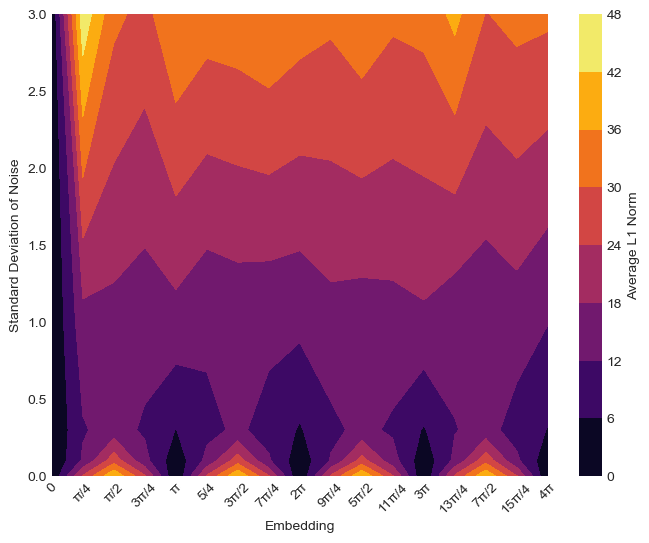

In [25]:
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5/4', '3π/2', '7π/4', '2π',
               '9π/4', '5π/2', '11π/4', '3π', '13π/4', '7π/2', '15π/4', '4π']

plt.figure(figsize = (8,6))
h = plt.contourf(X, Y, Z, cmap=cm.inferno )
plt.colorbar().set_label('Average L1 Norm')
plt.xlabel('Embedding')
plt.xticks(ticks = ticks, labels = labels, rotation = 45)
plt.ylabel('Standard Deviation of Noise')
plt.show()